# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

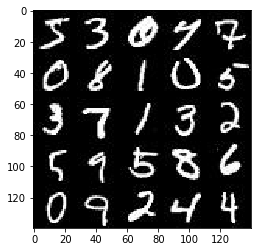

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

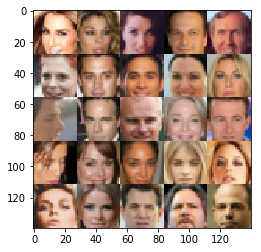

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim])
    l_rate = tf.placeholder(tf.float32, shape=[])

    return input_real, input_z, l_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.02
    with tf.variable_scope("discriminator", reuse=reuse):
        # Image size 28x28x1 or 28x28x3
        #conv = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        #conv = tf.layers.batch_normalization(conv)
        #conv = tf.nn.relu(conv)
        #conv = tf.maximum(alpha * conv, conv)
        # Image size 28x28x1 or 3

        conv = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        conv = tf.layers.batch_normalization(conv)
        #conv = tf.nn.relu(conv)
        conv = tf.maximum(alpha * conv, conv)
        # Image size 14x14x128

        conv = tf.layers.conv2d(images, 256, 5, strides=2, padding='same')
        conv = tf.layers.batch_normalization(conv)
        #conv = tf.nn.relu(conv)
        conv = tf.maximum(alpha * conv, conv)
        # Image size 7x7x256
        
        logits = tf.reshape(conv, [-1, 7*7*256])
        logits = tf.layers.dense(logits, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.02
    with tf.variable_scope("generator", reuse=(not is_train)):
        conv_t = tf.layers.dense(z, 7*7*256)
        conv_t = tf.reshape(conv_t, [-1, 7, 7, 256])
        conv_t = tf.layers.batch_normalization(conv_t, training=is_train)
        #conv_t = tf.nn.relu(conv_t)
        conv_t = tf.maximum(alpha * conv_t, conv_t)
        # Image size 7x7x256
        
        conv_t = tf.layers.conv2d_transpose(conv_t, 128, 5, strides=2, padding='same')
        conv_t = tf.layers.batch_normalization(conv_t, training=is_train)
        #conv_t = tf.nn.relu(conv_t)
        conv_t = tf.maximum(alpha * conv_t, conv_t)
        # Image size 14x14x128
        
        #conv_t = tf.layers.conv2d_transpose(conv_t, 64, 3, strides=1, padding='same')
        #conv_t = tf.layers.batch_normalization(conv_t, training=is_train)
        #conv_t = tf.nn.relu(conv_t)
        #conv_t = tf.maximum(alpha * conv_t, conv_t)
        # Image size 14x14x64
        
        conv_t = tf.layers.conv2d_transpose(conv_t, out_channel_dim, 5, strides=2, padding='same')
        # Image size 28x28xOut_channel_dim
        
        out = tf.tanh(conv_t) # Output
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    all_var = tf.trainable_variables()
    
    dis_var = [d for d in all_var if d.name.startswith('dis')]
    gen_var = [g for g in all_var if g.name.startswith('gen')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_var)
        d_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_var)

    return d_op, g_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 25
    out_channel_dim = len(data_image_mode)
    
    input_real, input_z, learn_r = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_r, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_count, batch_images in enumerate(get_batches(batch_size)):
                batch_i = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_i, input_z: batch_z, learn_r:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_r:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_r:learning_rate})
                
                if (batch_count % print_every) == 0: 
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    if (batch_count % (print_every*10)) == 0: 
                        show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
                        
                    print("Epoch {}/{}... Batch {}...".format(epoch_i+1, epoch_count, batch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    
        show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

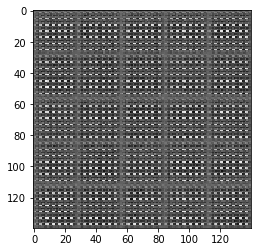

Epoch 1/2... Batch 0... Discriminator Loss: 1.4378... Generator Loss: 0.5704
Epoch 1/2... Batch 25... Discriminator Loss: 1.5622... Generator Loss: 0.5743
Epoch 1/2... Batch 50... Discriminator Loss: 1.5606... Generator Loss: 0.7147
Epoch 1/2... Batch 75... Discriminator Loss: 1.5948... Generator Loss: 0.6172
Epoch 1/2... Batch 100... Discriminator Loss: 1.5467... Generator Loss: 0.6799
Epoch 1/2... Batch 125... Discriminator Loss: 1.5727... Generator Loss: 0.6473
Epoch 1/2... Batch 150... Discriminator Loss: 1.5145... Generator Loss: 0.6744
Epoch 1/2... Batch 175... Discriminator Loss: 1.5121... Generator Loss: 0.6322
Epoch 1/2... Batch 200... Discriminator Loss: 1.5104... Generator Loss: 0.6550
Epoch 1/2... Batch 225... Discriminator Loss: 1.4422... Generator Loss: 0.7281


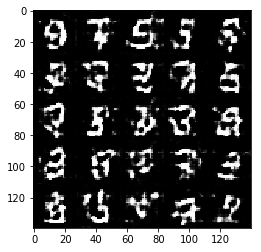

Epoch 1/2... Batch 250... Discriminator Loss: 1.4354... Generator Loss: 0.7012
Epoch 1/2... Batch 275... Discriminator Loss: 1.4330... Generator Loss: 0.6983
Epoch 1/2... Batch 300... Discriminator Loss: 1.4696... Generator Loss: 0.6480
Epoch 1/2... Batch 325... Discriminator Loss: 1.4336... Generator Loss: 0.7305
Epoch 1/2... Batch 350... Discriminator Loss: 1.4660... Generator Loss: 0.6585
Epoch 1/2... Batch 375... Discriminator Loss: 1.4595... Generator Loss: 0.6490
Epoch 1/2... Batch 400... Discriminator Loss: 1.4488... Generator Loss: 0.6703
Epoch 1/2... Batch 425... Discriminator Loss: 1.4960... Generator Loss: 0.6251
Epoch 1/2... Batch 450... Discriminator Loss: 1.4434... Generator Loss: 0.6892
Epoch 1/2... Batch 475... Discriminator Loss: 1.5041... Generator Loss: 0.6119


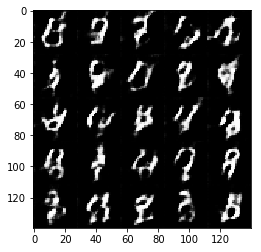

Epoch 1/2... Batch 500... Discriminator Loss: 1.4219... Generator Loss: 0.6969
Epoch 1/2... Batch 525... Discriminator Loss: 1.4517... Generator Loss: 0.6778
Epoch 1/2... Batch 550... Discriminator Loss: 1.4919... Generator Loss: 0.6269
Epoch 1/2... Batch 575... Discriminator Loss: 1.4041... Generator Loss: 0.7369
Epoch 1/2... Batch 600... Discriminator Loss: 1.4653... Generator Loss: 0.6505
Epoch 1/2... Batch 625... Discriminator Loss: 1.4044... Generator Loss: 0.7614
Epoch 1/2... Batch 650... Discriminator Loss: 1.4712... Generator Loss: 0.6454
Epoch 1/2... Batch 675... Discriminator Loss: 1.4450... Generator Loss: 0.6772
Epoch 1/2... Batch 700... Discriminator Loss: 1.4680... Generator Loss: 0.6639
Epoch 1/2... Batch 725... Discriminator Loss: 1.3938... Generator Loss: 0.7786


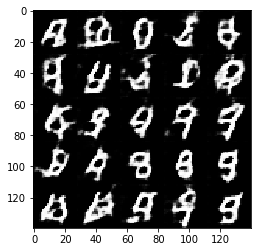

Epoch 1/2... Batch 750... Discriminator Loss: 1.4743... Generator Loss: 0.6402
Epoch 1/2... Batch 775... Discriminator Loss: 1.4555... Generator Loss: 0.6772
Epoch 1/2... Batch 800... Discriminator Loss: 1.4588... Generator Loss: 0.6830
Epoch 1/2... Batch 825... Discriminator Loss: 1.4665... Generator Loss: 0.6708
Epoch 1/2... Batch 850... Discriminator Loss: 1.4625... Generator Loss: 0.6696
Epoch 1/2... Batch 875... Discriminator Loss: 1.4136... Generator Loss: 0.7094
Epoch 1/2... Batch 900... Discriminator Loss: 1.4478... Generator Loss: 0.6746
Epoch 1/2... Batch 925... Discriminator Loss: 1.4644... Generator Loss: 0.6551


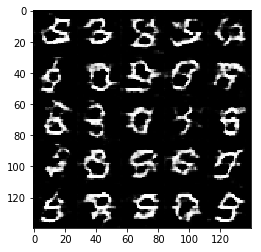

Epoch 2/2... Batch 0... Discriminator Loss: 1.4236... Generator Loss: 0.6943
Epoch 2/2... Batch 25... Discriminator Loss: 1.4177... Generator Loss: 0.7134
Epoch 2/2... Batch 50... Discriminator Loss: 1.4254... Generator Loss: 0.6913
Epoch 2/2... Batch 75... Discriminator Loss: 1.4492... Generator Loss: 0.6584
Epoch 2/2... Batch 100... Discriminator Loss: 1.4470... Generator Loss: 0.6833
Epoch 2/2... Batch 125... Discriminator Loss: 1.4889... Generator Loss: 0.6338
Epoch 2/2... Batch 150... Discriminator Loss: 1.4315... Generator Loss: 0.7141
Epoch 2/2... Batch 175... Discriminator Loss: 1.4600... Generator Loss: 0.6562
Epoch 2/2... Batch 200... Discriminator Loss: 1.4419... Generator Loss: 0.6816
Epoch 2/2... Batch 225... Discriminator Loss: 1.4811... Generator Loss: 0.6473


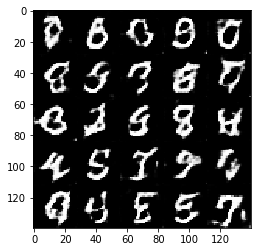

Epoch 2/2... Batch 250... Discriminator Loss: 1.4502... Generator Loss: 0.6832
Epoch 2/2... Batch 275... Discriminator Loss: 1.4628... Generator Loss: 0.6567
Epoch 2/2... Batch 300... Discriminator Loss: 1.4208... Generator Loss: 0.7256
Epoch 2/2... Batch 325... Discriminator Loss: 1.3807... Generator Loss: 0.7924
Epoch 2/2... Batch 350... Discriminator Loss: 1.4236... Generator Loss: 0.7003
Epoch 2/2... Batch 375... Discriminator Loss: 1.4193... Generator Loss: 0.7141
Epoch 2/2... Batch 400... Discriminator Loss: 1.4356... Generator Loss: 0.7078
Epoch 2/2... Batch 425... Discriminator Loss: 1.4305... Generator Loss: 0.7100
Epoch 2/2... Batch 450... Discriminator Loss: 1.4133... Generator Loss: 0.7293
Epoch 2/2... Batch 475... Discriminator Loss: 1.4554... Generator Loss: 0.6695


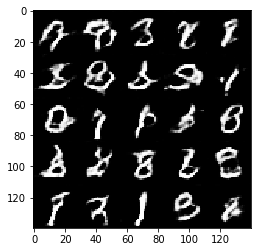

Epoch 2/2... Batch 500... Discriminator Loss: 1.4491... Generator Loss: 0.6766
Epoch 2/2... Batch 525... Discriminator Loss: 1.4631... Generator Loss: 0.6681
Epoch 2/2... Batch 550... Discriminator Loss: 1.4538... Generator Loss: 0.6908
Epoch 2/2... Batch 575... Discriminator Loss: 1.4044... Generator Loss: 0.7555
Epoch 2/2... Batch 600... Discriminator Loss: 1.4382... Generator Loss: 0.6979
Epoch 2/2... Batch 625... Discriminator Loss: 1.4670... Generator Loss: 0.6641
Epoch 2/2... Batch 650... Discriminator Loss: 1.4282... Generator Loss: 0.7349
Epoch 2/2... Batch 675... Discriminator Loss: 1.4348... Generator Loss: 0.7199
Epoch 2/2... Batch 700... Discriminator Loss: 1.4965... Generator Loss: 0.6290
Epoch 2/2... Batch 725... Discriminator Loss: 1.4569... Generator Loss: 0.6685


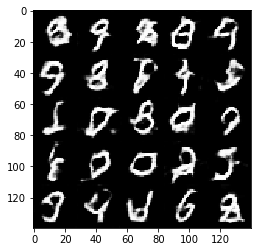

Epoch 2/2... Batch 750... Discriminator Loss: 1.4731... Generator Loss: 0.6466
Epoch 2/2... Batch 775... Discriminator Loss: 1.4983... Generator Loss: 0.6316
Epoch 2/2... Batch 800... Discriminator Loss: 1.4307... Generator Loss: 0.6884
Epoch 2/2... Batch 825... Discriminator Loss: 1.5293... Generator Loss: 0.5785
Epoch 2/2... Batch 850... Discriminator Loss: 1.4713... Generator Loss: 0.6584
Epoch 2/2... Batch 875... Discriminator Loss: 1.4538... Generator Loss: 0.6791
Epoch 2/2... Batch 900... Discriminator Loss: 1.4241... Generator Loss: 0.7092
Epoch 2/2... Batch 925... Discriminator Loss: 1.4631... Generator Loss: 0.6707


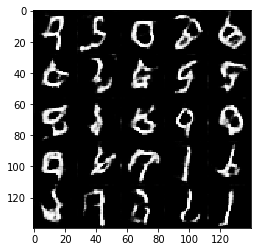

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

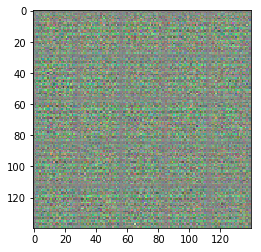

Epoch 1/1... Batch 0... Discriminator Loss: 1.4259... Generator Loss: 0.6618
Epoch 1/1... Batch 25... Discriminator Loss: 1.4476... Generator Loss: 0.5926
Epoch 1/1... Batch 50... Discriminator Loss: 1.4350... Generator Loss: 0.6418
Epoch 1/1... Batch 75... Discriminator Loss: 1.4194... Generator Loss: 0.6919
Epoch 1/1... Batch 100... Discriminator Loss: 1.3988... Generator Loss: 0.7175
Epoch 1/1... Batch 125... Discriminator Loss: 1.4256... Generator Loss: 0.6628
Epoch 1/1... Batch 150... Discriminator Loss: 1.4113... Generator Loss: 0.6828
Epoch 1/1... Batch 175... Discriminator Loss: 1.4026... Generator Loss: 0.7027
Epoch 1/1... Batch 200... Discriminator Loss: 1.3861... Generator Loss: 0.7061
Epoch 1/1... Batch 225... Discriminator Loss: 1.4036... Generator Loss: 0.6897


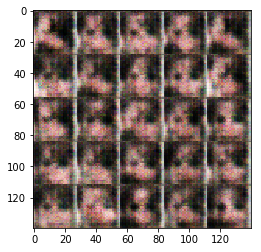

Epoch 1/1... Batch 250... Discriminator Loss: 1.4279... Generator Loss: 0.6495
Epoch 1/1... Batch 275... Discriminator Loss: 1.3935... Generator Loss: 0.7092
Epoch 1/1... Batch 300... Discriminator Loss: 1.3686... Generator Loss: 0.7214
Epoch 1/1... Batch 325... Discriminator Loss: 1.3789... Generator Loss: 0.7179
Epoch 1/1... Batch 350... Discriminator Loss: 1.3818... Generator Loss: 0.7134
Epoch 1/1... Batch 375... Discriminator Loss: 1.3963... Generator Loss: 0.7105
Epoch 1/1... Batch 400... Discriminator Loss: 1.4076... Generator Loss: 0.6846
Epoch 1/1... Batch 425... Discriminator Loss: 1.4173... Generator Loss: 0.6610
Epoch 1/1... Batch 450... Discriminator Loss: 1.3954... Generator Loss: 0.6908
Epoch 1/1... Batch 475... Discriminator Loss: 1.3945... Generator Loss: 0.6729


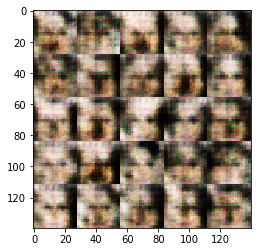

Epoch 1/1... Batch 500... Discriminator Loss: 1.3873... Generator Loss: 0.6994
Epoch 1/1... Batch 525... Discriminator Loss: 1.3967... Generator Loss: 0.6910
Epoch 1/1... Batch 550... Discriminator Loss: 1.4077... Generator Loss: 0.6792
Epoch 1/1... Batch 575... Discriminator Loss: 1.4092... Generator Loss: 0.6808
Epoch 1/1... Batch 600... Discriminator Loss: 1.4208... Generator Loss: 0.6765
Epoch 1/1... Batch 625... Discriminator Loss: 1.4026... Generator Loss: 0.6939
Epoch 1/1... Batch 650... Discriminator Loss: 1.4084... Generator Loss: 0.6807
Epoch 1/1... Batch 675... Discriminator Loss: 1.4217... Generator Loss: 0.6604
Epoch 1/1... Batch 700... Discriminator Loss: 1.4311... Generator Loss: 0.6556
Epoch 1/1... Batch 725... Discriminator Loss: 1.4151... Generator Loss: 0.6684


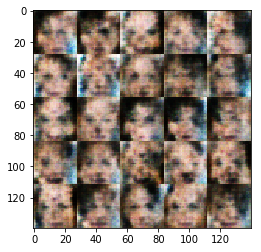

Epoch 1/1... Batch 750... Discriminator Loss: 1.3814... Generator Loss: 0.7141
Epoch 1/1... Batch 775... Discriminator Loss: 1.4067... Generator Loss: 0.6789
Epoch 1/1... Batch 800... Discriminator Loss: 1.4101... Generator Loss: 0.6753
Epoch 1/1... Batch 825... Discriminator Loss: 1.4068... Generator Loss: 0.6824
Epoch 1/1... Batch 850... Discriminator Loss: 1.4130... Generator Loss: 0.6695
Epoch 1/1... Batch 875... Discriminator Loss: 1.3780... Generator Loss: 0.7148
Epoch 1/1... Batch 900... Discriminator Loss: 1.4205... Generator Loss: 0.6662
Epoch 1/1... Batch 925... Discriminator Loss: 1.4091... Generator Loss: 0.6769
Epoch 1/1... Batch 950... Discriminator Loss: 1.4130... Generator Loss: 0.6671
Epoch 1/1... Batch 975... Discriminator Loss: 1.4150... Generator Loss: 0.6725


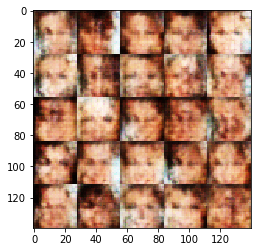

Epoch 1/1... Batch 1000... Discriminator Loss: 1.4079... Generator Loss: 0.6802
Epoch 1/1... Batch 1025... Discriminator Loss: 1.4026... Generator Loss: 0.6874
Epoch 1/1... Batch 1050... Discriminator Loss: 1.4061... Generator Loss: 0.6830
Epoch 1/1... Batch 1075... Discriminator Loss: 1.4037... Generator Loss: 0.6959
Epoch 1/1... Batch 1100... Discriminator Loss: 1.3904... Generator Loss: 0.7058
Epoch 1/1... Batch 1125... Discriminator Loss: 1.3966... Generator Loss: 0.6929
Epoch 1/1... Batch 1150... Discriminator Loss: 1.4048... Generator Loss: 0.6800
Epoch 1/1... Batch 1175... Discriminator Loss: 1.3965... Generator Loss: 0.6950
Epoch 1/1... Batch 1200... Discriminator Loss: 1.3935... Generator Loss: 0.6945
Epoch 1/1... Batch 1225... Discriminator Loss: 1.3910... Generator Loss: 0.6946


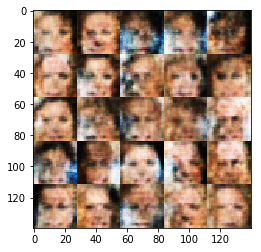

Epoch 1/1... Batch 1250... Discriminator Loss: 1.3955... Generator Loss: 0.6891
Epoch 1/1... Batch 1275... Discriminator Loss: 1.3983... Generator Loss: 0.6859
Epoch 1/1... Batch 1300... Discriminator Loss: 1.4011... Generator Loss: 0.6735
Epoch 1/1... Batch 1325... Discriminator Loss: 1.4024... Generator Loss: 0.6768
Epoch 1/1... Batch 1350... Discriminator Loss: 1.4002... Generator Loss: 0.6804
Epoch 1/1... Batch 1375... Discriminator Loss: 1.3971... Generator Loss: 0.6916
Epoch 1/1... Batch 1400... Discriminator Loss: 1.3950... Generator Loss: 0.6965
Epoch 1/1... Batch 1425... Discriminator Loss: 1.4093... Generator Loss: 0.6717
Epoch 1/1... Batch 1450... Discriminator Loss: 1.3858... Generator Loss: 0.6964
Epoch 1/1... Batch 1475... Discriminator Loss: 1.4004... Generator Loss: 0.6848


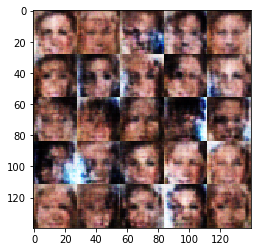

Epoch 1/1... Batch 1500... Discriminator Loss: 1.4003... Generator Loss: 0.6840
Epoch 1/1... Batch 1525... Discriminator Loss: 1.4003... Generator Loss: 0.6844
Epoch 1/1... Batch 1550... Discriminator Loss: 1.4030... Generator Loss: 0.6764
Epoch 1/1... Batch 1575... Discriminator Loss: 1.3826... Generator Loss: 0.7087
Epoch 1/1... Batch 1600... Discriminator Loss: 1.3935... Generator Loss: 0.6941
Epoch 1/1... Batch 1625... Discriminator Loss: 1.3912... Generator Loss: 0.6948
Epoch 1/1... Batch 1650... Discriminator Loss: 1.3880... Generator Loss: 0.6992
Epoch 1/1... Batch 1675... Discriminator Loss: 1.4025... Generator Loss: 0.6722
Epoch 1/1... Batch 1700... Discriminator Loss: 1.3905... Generator Loss: 0.6954
Epoch 1/1... Batch 1725... Discriminator Loss: 1.4015... Generator Loss: 0.6794


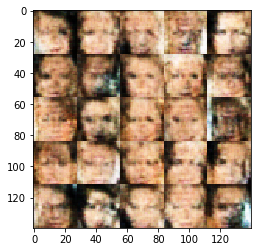

Epoch 1/1... Batch 1750... Discriminator Loss: 1.3972... Generator Loss: 0.6908
Epoch 1/1... Batch 1775... Discriminator Loss: 1.3914... Generator Loss: 0.6969
Epoch 1/1... Batch 1800... Discriminator Loss: 1.3964... Generator Loss: 0.6949
Epoch 1/1... Batch 1825... Discriminator Loss: 1.3919... Generator Loss: 0.6939
Epoch 1/1... Batch 1850... Discriminator Loss: 1.3908... Generator Loss: 0.6985
Epoch 1/1... Batch 1875... Discriminator Loss: 1.4053... Generator Loss: 0.6748
Epoch 1/1... Batch 1900... Discriminator Loss: 1.3796... Generator Loss: 0.7055
Epoch 1/1... Batch 1925... Discriminator Loss: 1.4120... Generator Loss: 0.6644
Epoch 1/1... Batch 1950... Discriminator Loss: 1.3856... Generator Loss: 0.6963
Epoch 1/1... Batch 1975... Discriminator Loss: 1.3937... Generator Loss: 0.6939


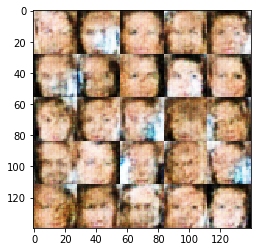

Epoch 1/1... Batch 2000... Discriminator Loss: 1.4026... Generator Loss: 0.6794
Epoch 1/1... Batch 2025... Discriminator Loss: 1.3895... Generator Loss: 0.6912
Epoch 1/1... Batch 2050... Discriminator Loss: 1.3696... Generator Loss: 0.7182
Epoch 1/1... Batch 2075... Discriminator Loss: 1.3994... Generator Loss: 0.6870
Epoch 1/1... Batch 2100... Discriminator Loss: 1.3957... Generator Loss: 0.6966
Epoch 1/1... Batch 2125... Discriminator Loss: 1.3918... Generator Loss: 0.6897
Epoch 1/1... Batch 2150... Discriminator Loss: 1.3944... Generator Loss: 0.6887
Epoch 1/1... Batch 2175... Discriminator Loss: 1.3930... Generator Loss: 0.6883
Epoch 1/1... Batch 2200... Discriminator Loss: 1.3878... Generator Loss: 0.6944
Epoch 1/1... Batch 2225... Discriminator Loss: 1.3876... Generator Loss: 0.6938


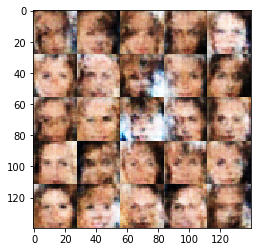

Epoch 1/1... Batch 2250... Discriminator Loss: 1.3914... Generator Loss: 0.6924
Epoch 1/1... Batch 2275... Discriminator Loss: 1.3986... Generator Loss: 0.6812
Epoch 1/1... Batch 2300... Discriminator Loss: 1.3969... Generator Loss: 0.6801
Epoch 1/1... Batch 2325... Discriminator Loss: 1.3967... Generator Loss: 0.6833
Epoch 1/1... Batch 2350... Discriminator Loss: 1.3880... Generator Loss: 0.6976
Epoch 1/1... Batch 2375... Discriminator Loss: 1.3983... Generator Loss: 0.6876
Epoch 1/1... Batch 2400... Discriminator Loss: 1.3919... Generator Loss: 0.6943
Epoch 1/1... Batch 2425... Discriminator Loss: 1.4049... Generator Loss: 0.6709
Epoch 1/1... Batch 2450... Discriminator Loss: 1.3997... Generator Loss: 0.6761
Epoch 1/1... Batch 2475... Discriminator Loss: 1.3938... Generator Loss: 0.6858


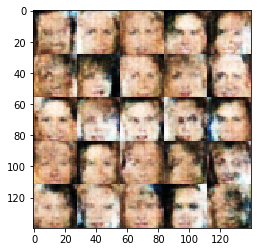

Epoch 1/1... Batch 2500... Discriminator Loss: 1.3995... Generator Loss: 0.6797
Epoch 1/1... Batch 2525... Discriminator Loss: 1.3962... Generator Loss: 0.6838
Epoch 1/1... Batch 2550... Discriminator Loss: 1.3979... Generator Loss: 0.6806
Epoch 1/1... Batch 2575... Discriminator Loss: 1.3976... Generator Loss: 0.6827
Epoch 1/1... Batch 2600... Discriminator Loss: 1.3919... Generator Loss: 0.6926
Epoch 1/1... Batch 2625... Discriminator Loss: 1.3944... Generator Loss: 0.6848
Epoch 1/1... Batch 2650... Discriminator Loss: 1.3863... Generator Loss: 0.6975
Epoch 1/1... Batch 2675... Discriminator Loss: 1.3936... Generator Loss: 0.6800
Epoch 1/1... Batch 2700... Discriminator Loss: 1.3879... Generator Loss: 0.6961
Epoch 1/1... Batch 2725... Discriminator Loss: 1.3869... Generator Loss: 0.6974


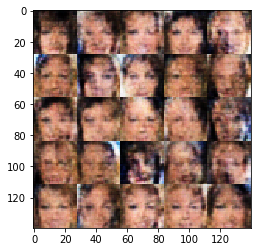

Epoch 1/1... Batch 2750... Discriminator Loss: 1.3821... Generator Loss: 0.6997
Epoch 1/1... Batch 2775... Discriminator Loss: 1.3943... Generator Loss: 0.6775
Epoch 1/1... Batch 2800... Discriminator Loss: 1.3819... Generator Loss: 0.6998
Epoch 1/1... Batch 2825... Discriminator Loss: 1.3815... Generator Loss: 0.6994
Epoch 1/1... Batch 2850... Discriminator Loss: 1.3807... Generator Loss: 0.7090
Epoch 1/1... Batch 2875... Discriminator Loss: 1.3859... Generator Loss: 0.7010
Epoch 1/1... Batch 2900... Discriminator Loss: 1.3827... Generator Loss: 0.6987
Epoch 1/1... Batch 2925... Discriminator Loss: 1.3845... Generator Loss: 0.6990
Epoch 1/1... Batch 2950... Discriminator Loss: 1.3876... Generator Loss: 0.6976
Epoch 1/1... Batch 2975... Discriminator Loss: 1.3950... Generator Loss: 0.6852


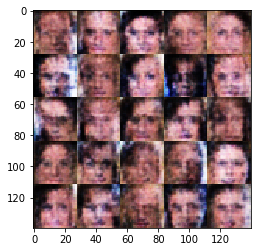

Epoch 1/1... Batch 3000... Discriminator Loss: 1.3900... Generator Loss: 0.6825
Epoch 1/1... Batch 3025... Discriminator Loss: 1.3906... Generator Loss: 0.6936
Epoch 1/1... Batch 3050... Discriminator Loss: 1.3901... Generator Loss: 0.6878
Epoch 1/1... Batch 3075... Discriminator Loss: 1.3941... Generator Loss: 0.6833
Epoch 1/1... Batch 3100... Discriminator Loss: 1.3886... Generator Loss: 0.6927
Epoch 1/1... Batch 3125... Discriminator Loss: 1.3866... Generator Loss: 0.6967
Epoch 1/1... Batch 3150... Discriminator Loss: 1.3897... Generator Loss: 0.6900


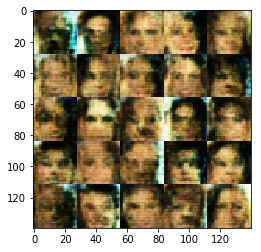

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.